In [8]:
import matplotlib.pyplot as plt
import wisc_ecephys_tools as wet
import xarray as xr
from ecephys import plot, wne

from findlay2025a import core, plotting, sharp_waves
from findlay2025a.constants import Experiments as Exps

In [13]:
sglx_subject = wet.get_sglx_subject("CNPIX14-Francis")
experiment = Exps.NOD

nb = core.get_project("seahorse")
s3 = core.get_project("shared")

spws = sharp_waves.read_spws(sglx_subject.name, experiment)
delta = xr.open_dataarray(
    core.get_cortical_bandpower_file(sglx_subject.name, experiment, "delta")
)
light_dark_periods, light_dark_period_labels = wet.shared.get_light_dark_periods(
    experiment, sglx_subject
)
hg = wne.utils.load_raw_float_hypnogram(
    s3, experiment, sglx_subject.name, simplify=True
)

In [14]:
bslp_start = light_dark_periods[0][0]
bslp_end = light_dark_periods[0][1]
is_nrem = hg.keep_states(["NREM"]).covers_time(delta.time)
is_bsl = (delta.time >= bslp_start) & (delta.time <= bslp_end)
bsl_nrem_delta_mean = delta.sel(time=(is_nrem & is_bsl)).mean()
delta = (delta / bsl_nrem_delta_mean) * 100

In [15]:
is_nrem = hg.keep_states(["NREM"]).covers_time(spws.pk_time)
is_bsl = (spws.pk_time >= bslp_start) & (spws.pk_time <= bslp_end)
bsl_nrem_spws = spws[is_nrem & is_bsl]
bsl_nrem_spw_amp_mean = bsl_nrem_spws["pk_amp"].mean()
spws["pk_amp"] = (spws["pk_amp"] / bsl_nrem_spw_amp_mean) * 100

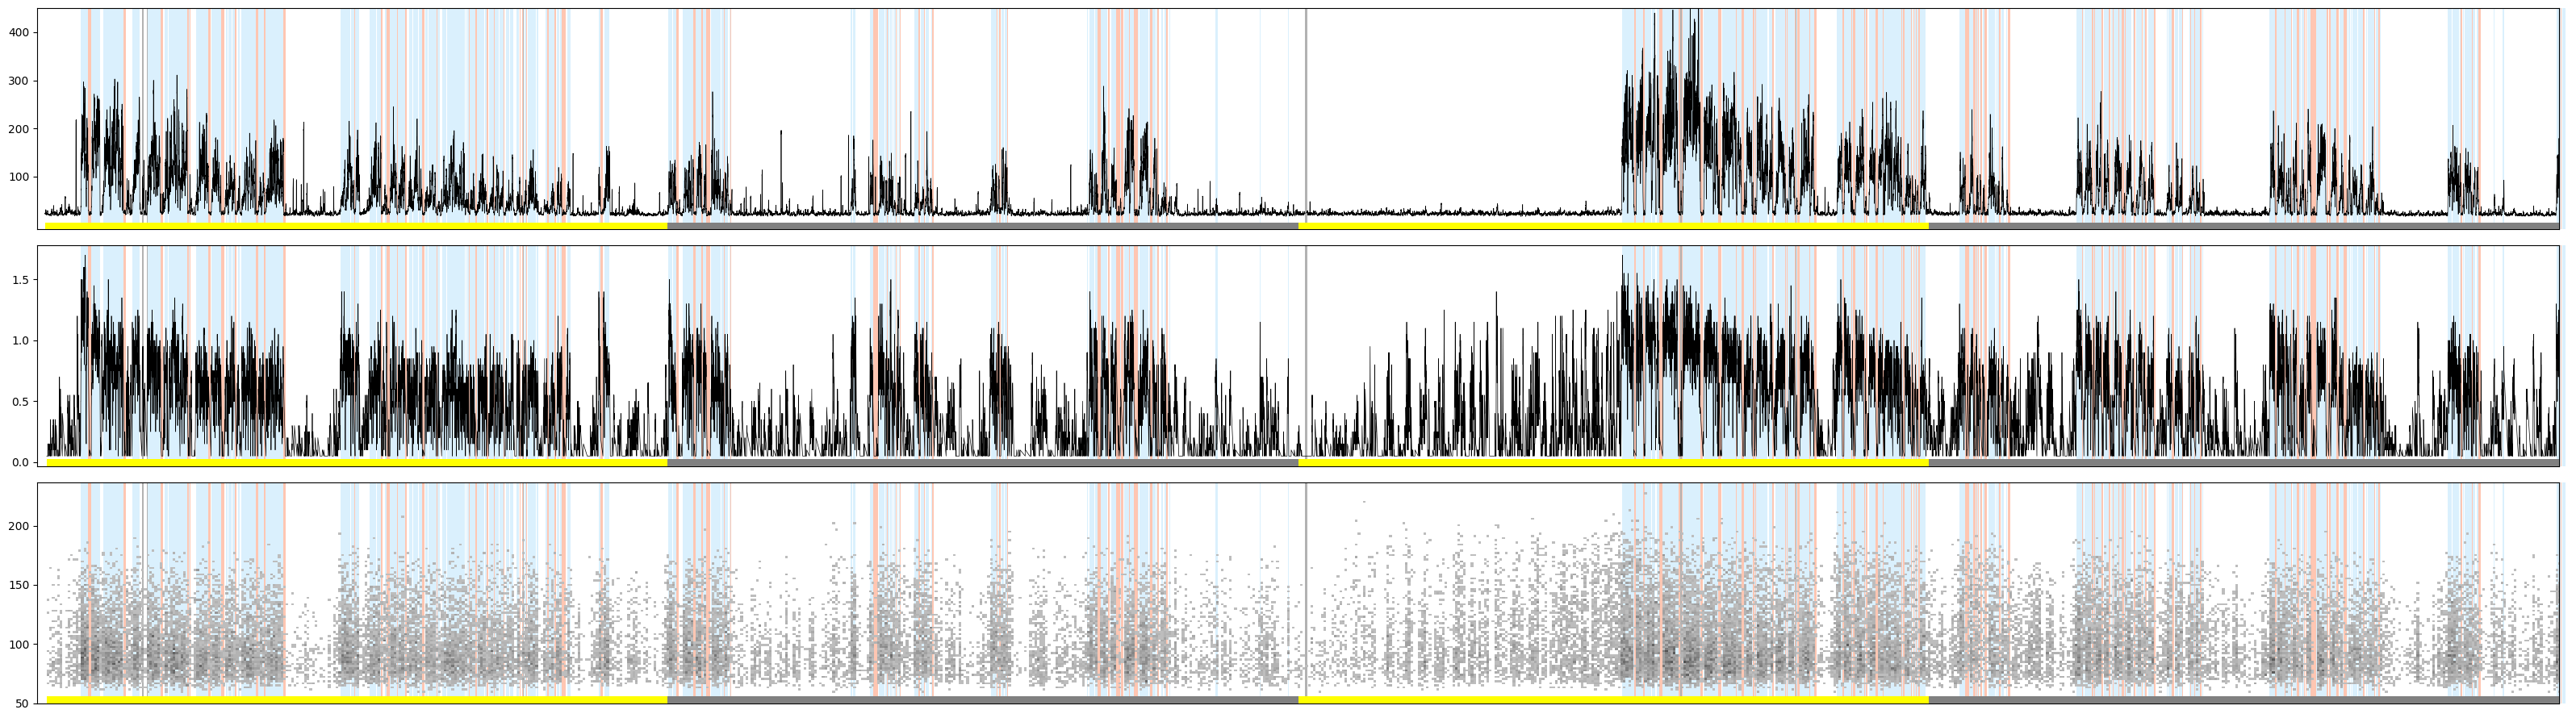

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(32, 9))
plotting.plot_swa_timetrace(delta, axes[0], smoothing=14)
plotting.plot_event_rate_timetrace(spws, axes[1])
plotting.plot_event_amplitude_timehist(spws, ax=axes[2])
for ax in axes:
    plot.plot_hypnogram_overlay(hg, ax=ax, state_colors=plot.publication_colors)
    wet.shared.plot_lights_overlay(
        light_dark_periods, light_dark_period_labels, ax=ax, ymin=0, ymax=0.03
    )
    ax.set_xlim((light_dark_periods[0][0], light_dark_periods[-1][-1]))
    ax.set_ylabel(None)
axes[0].set_ylim((None, 450))
axes[0].set_yticks([100, 200, 300, 400])
axes[1].set_yticks([0, 0.5, 1.0, 1.5])
axes[2].set_yticks([50, 100, 150, 200])

plt.tight_layout()

# fig.savefig(nb.get_project_file('figures/nod_spws.svg'), bbox_inches='tight')
# fig.savefig(nb.get_project_file('figures/nod_spws.png'), dpi=600, bbox_inches='tight')